In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import load_sample_image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, metrics, activations, applications
from tensorflow.keras.datasets import fashion_mnist
import tensorflow_datasets as tfds

# Deep Computer Vision Using Convolutional Neural Networks

## Convolutional Layers

In [2]:
# Load sample images

china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255

images = np.array([china, flower])

batch_size, height, width, channels = images.shape

In [3]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

In [4]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-01-26 16:53:18.083019: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-26 16:53:18.083405: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


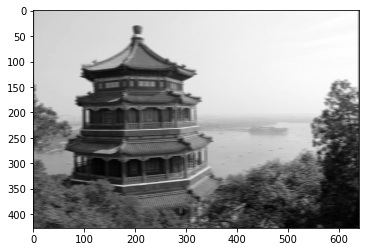

In [5]:
plt.imshow(outputs[0, :, :, 1], cmap='gray')
plt.show()

In [6]:
# Use the convolutional layer implemented by Keras

conv = layers.Conv2D(filters=32, kernel_size=1, strides=3, padding='same', activation='relu')

In [7]:
images_conv = conv(images)
images_conv

<tf.Tensor: shape=(2, 143, 214, 32), dtype=float32, numpy=
array([[[[1.36929095e-01, 0.00000000e+00, 1.25264496e-01, ...,
          1.73746482e-01, 0.00000000e+00, 0.00000000e+00],
         [1.36929095e-01, 0.00000000e+00, 1.25264496e-01, ...,
          1.73746482e-01, 0.00000000e+00, 0.00000000e+00],
         [1.36929095e-01, 0.00000000e+00, 1.25264496e-01, ...,
          1.73746482e-01, 0.00000000e+00, 0.00000000e+00],
         ...,
         [1.43787920e-01, 0.00000000e+00, 1.25369295e-01, ...,
          3.09187919e-01, 0.00000000e+00, 0.00000000e+00],
         [1.43555954e-01, 0.00000000e+00, 1.25695989e-01, ...,
          3.13094884e-01, 0.00000000e+00, 0.00000000e+00],
         [1.44110933e-01, 0.00000000e+00, 1.26187265e-01, ...,
          3.14375192e-01, 0.00000000e+00, 0.00000000e+00]],

        [[1.37484044e-01, 0.00000000e+00, 1.25755772e-01, ...,
          1.75026819e-01, 0.00000000e+00, 0.00000000e+00],
         [1.37484044e-01, 0.00000000e+00, 1.25755772e-01, ...,
        

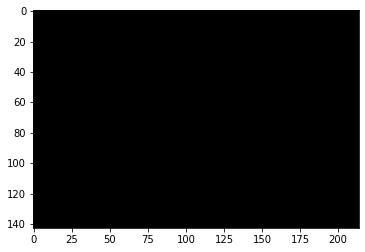

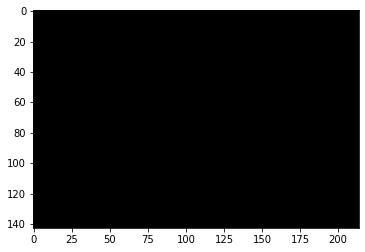

In [8]:
for image in images_conv:
    plt.imshow(image[:,:, 30], cmap='gray')
    plt.show()

## Pooling Layers

In [9]:
max_pool = layers.MaxPool2D(pool_size=8)

images_maxpool = max_pool(images)

In [10]:
images_maxpool.shape

TensorShape([2, 53, 80, 3])

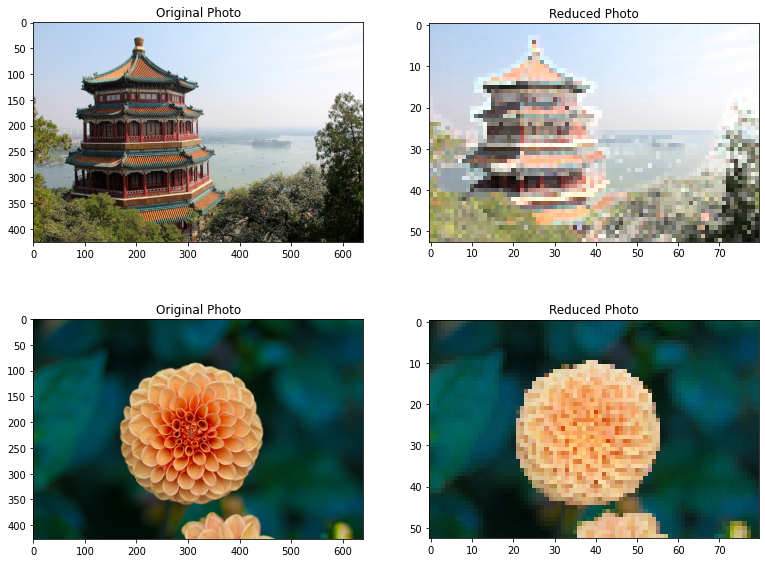

In [11]:
plt.figure(figsize=(13, 10))

plt.subplot(2, 2, 1, title='Original Photo')
plt.imshow(images[0])

plt.subplot(2, 2, 2, title='Reduced Photo')
plt.imshow(images_maxpool[0])

plt.subplot(2, 2, 3, title='Original Photo')
plt.imshow(images[1])

plt.subplot(2, 2, 4, title='Reduced Photo')
plt.imshow(images_maxpool[1])

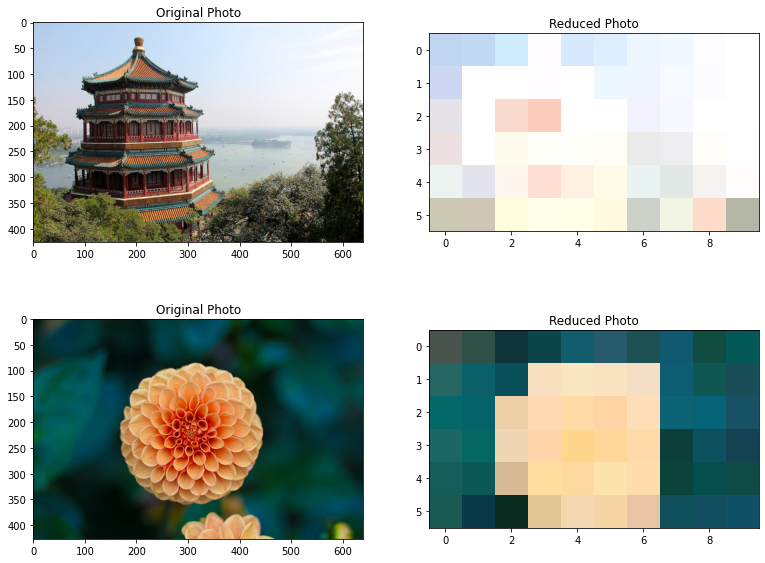

In [12]:
image_maxpool_2 = max_pool(images_maxpool)

plt.figure(figsize=(13, 10))

plt.subplot(2, 2, 1, title='Original Photo')
plt.imshow(images[0])

plt.subplot(2, 2, 2, title='Reduced Photo')
plt.imshow(image_maxpool_2[0])

plt.subplot(2, 2, 3, title='Original Photo')
plt.imshow(images[1])

plt.subplot(2, 2, 4, title='Reduced Photo')
plt.imshow(image_maxpool_2[1])

In [13]:
# Implement Depthwise max pooling layer

depth_pool = layers.Lambda(
    lambda x: tf.nn.max_pool(x, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding='VALID')
)

In [14]:
# Implement Global average pool layer 
global_avg_pool = layers.GlobalAvgPool2D()

# This layer is equivalent to the previous layer
global_avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=[1, 2]))

In [15]:
# Let's import the fashion mnist

(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, test_size=0.2)

In [16]:
class CustomConvolution(layers.Layer):
    
    def __init__(self, n_filters, kernel_size=3, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.n_filters = n_filters
        self.kernel_size = kernel_size
        self.activation = tf.keras.activations.get(activation)
        self.hidden_layers = [
            layers.Conv2D(n_filters, kernel_size, activation=activation, padding='same'),
            layers.Conv2D(n_filters, kernel_size, activation=activation, padding='same'),
            layers.MaxPooling2D(2)
        ]
    
    
    def call(self, inputs):
        z = inputs
        for layer in self.hidden_layers:
            z = layer(z)
        return z
    
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config,
                'n_filters' : self.n_filters,
                'kernel_size': self.kernel_size,
                'activation' : self.activation}
        

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(15)

model = models.Sequential([
    layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=[28, 28, 1]),
    layers.MaxPooling2D(2),
    CustomConvolution(128, 3, 'relu'),
    CustomConvolution(256, 3, 'relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

In [18]:
# Compile the model 

optimizer = optimizers.Nadam()

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=[metrics.SparseCategoricalAccuracy(name='accuracy_model')])

# Train the model

early_stopping_cb = callbacks.EarlyStopping(patience=15, restore_best_weights=True)
cb_list = [early_stopping_cb]

history_model = model.fit(x_train, y_train,
                          validation_data=[x_valid, y_valid],
                          epochs=350,
                          batch_size=500,
                          callbacks=cb_list)

evaluation = model.evaluate(x_test, y_test, verbose=0)
accuracy_model = round(evaluation[1], 8) * 100
loss_model = round(evaluation[0], 10)

print(f'The Accuracy of the model is {accuracy_model}%')
print(f'The Sparse Categorical Crossentropy of the model is {loss_model}')

2022-01-26 16:05:29.975520: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/350


2022-01-26 16:05:30.420094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - ETA: 0s - loss: 1.4805 - accuracy_model: 0.5123

2022-01-26 16:05:42.514501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 13s 131ms/step - loss: 1.4805 - accuracy_model: 0.5123 - val_loss: 0.5492 - val_accuracy_model: 0.7987
Epoch 2/350
96/96 [==============================] - 12s 130ms/step - loss: 0.6693 - accuracy_model: 0.7735 - val_loss: 0.3714 - val_accuracy_model: 0.8673
Epoch 3/350
96/96 [==============================] - 12s 130ms/step - loss: 0.4979 - accuracy_model: 0.8362 - val_loss: 0.3290 - val_accuracy_model: 0.8811
Epoch 4/350
96/96 [==============================] - 13s 130ms/step - loss: 0.4168 - accuracy_model: 0.8629 - val_loss: 0.3101 - val_accuracy_model: 0.8915
Epoch 5/350
96/96 [==============================] - 13s 130ms/step - loss: 0.3640 - accuracy_model: 0.8802 - val_loss: 0.2738 - val_accuracy_model: 0.8997
Epoch 6/350
96/96 [==============================] - 13s 132ms/step - loss: 0.3255 - accuracy_model: 0.8926 - val_loss: 0.2640 - val_accuracy_model: 0.9013
Epoch 7/350
96/96 [==============================] - 13s 131ms/step - loss: 

2022-01-26 16:10:42.882942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


The Accuracy of the model is 90.950006%
The Sparse Categorical Crossentropy of the model is 0.2630577385


## Implementing ResNet-34 CNN Using Keras

In [18]:
# Create the residual unit (RU)
class ResidualUnit(layers.Layer):
    
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.strides = strides
        self.activation = activations.get(activation)
        
        self.main_layers = [
            layers.Conv2D(filters, 3, strides=strides, padding='same', use_bias=False),
            layers.BatchNormalization(),
            self.activation,
            layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False),
            layers.BatchNormalization()
        ]
        
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                layers.Conv2D(filters, 1, strides=strides, padding='same', use_bias=False),
                layers.BatchNormalization()
            ]
    
    
    def call(self, inputs):
        z = inputs
        for layer in self.main_layers:
            z = layer(z)
        
        skip_z = inputs
        for layer in self.skip_layers:
            skip_z = layer(skip_z)
        
        return self.activation(z + skip_z)

In [19]:
resnet34_model = models.Sequential()
resnet34_model.add(layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3],
                                 padding='same', use_bias=False))
resnet34_model.add(layers.BatchNormalization())
resnet34_model.add(layers.Activation('relu'))
resnet34_model.add(layers.MaxPool2D(pool_size=3, strides=2, padding='same'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    resnet34_model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
resnet34_model.add(layers.GlobalAvgPool2D())
resnet34_model.add(layers.Flatten())
resnet34_model.add(layers.Dense(10, activation='softmax'))

## Using Pretrained Models from Keras

In [20]:
resnet50_model = applications.resnet50.ResNet50(weights='imagenet')

In [21]:
# Resize images
images_resized = tf.image.resize(images, [224, 224])

# Preprocess the images 
inputs = applications.resnet50.preprocess_input(images_resized * 255)

# Get the predictions 
y_proba = resnet50_model.predict(inputs)

2022-01-26 16:53:32.899225: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-26 16:53:33.250770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [22]:
top_k = applications.resnet50.decode_predictions(y_proba, top=5)
for image_index in range(len(images)):
    print(f'Image #{image_index}')
    for class_id, name, y_proba in top_k[image_index]:
        print(f'{class_id} - {name}\t{round(y_proba*100, 2)}%')

Image #0
n02825657 - bell_cote	82.35%
n03877845 - palace	6.75%
n03781244 - monastery	4.19%
n02980441 - castle	3.16%
n03028079 - church	1.0%
Image #1
n03530642 - honeycomb	49.81%
n13040303 - stinkhorn	33.96%
n02206856 - bee	4.35%
n11939491 - daisy	3.23%
n12985857 - coral_fungus	2.66%


## Pretrained Models for Transfer Learning

In [62]:
dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)
dataset_size = info.splits['train'].num_examples
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes

In [63]:

split_list = ['train[:75%]', 'train[75%:90%]', 'train[90%:]']

train_set, valid_set, test_set = tfds.load('tf_flowers', 
                                           split = split_list, 
                                           as_supervised = True)

In [64]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = applications.xception.preprocess_input(resized_image)
    return final_image, label

In [65]:
# Apply the preprocess to the three sets
batch_size = 500
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(1)

In [66]:
tf.keras.backend.clear_session()
tf.random.set_seed(15)

base_model = applications.xception.Xception(weights='imagenet', include_top=False)

avg = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(n_classes, activation='softmax')(avg)
xception_model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [67]:
# Freeze the pretrained layers
for layer in base_model.layers:
    layer.trainable = False

In [68]:
# Compile the model
optimizer = optimizers.SGD(learning_rate=0.01, momentum=0.99, nesterov=True)
xception_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=optimizer, 
                       metrics=metrics.SparseCategoricalAccuracy(name='model_accuracy'))

# Callbacks of the model
early_stopping_cb = callbacks.EarlyStopping(patience=15, restore_best_weights=True)

# Train the model
history_xception = xception_model.fit(train_set,
                                      validation_data=valid_set,
                                      epochs=10)

evaluation = xception_model.evaluate(test_set)
print(f'The accuray of the model is {round(evaluation[1], 4) * 100}%')

Epoch 1/10


2022-01-26 18:28:14.928547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.4891 - model_accuracy: 0.3554

2022-01-26 18:28:36.346507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 27s 4s/step - loss: 1.4891 - model_accuracy: 0.3554 - val_loss: 0.9834 - val_model_accuracy: 0.7042
Epoch 2/10
6/6 [==============================] - 25s 4s/step - loss: 0.8221 - model_accuracy: 0.7275 - val_loss: 0.6031 - val_model_accuracy: 0.7967
Epoch 3/10
6/6 [==============================] - 25s 4s/step - loss: 0.5681 - model_accuracy: 0.7994 - val_loss: 0.4839 - val_model_accuracy: 0.8203
Epoch 4/10
6/6 [==============================] - 25s 4s/step - loss: 0.4948 - model_accuracy: 0.8172 - val_loss: 0.4418 - val_model_accuracy: 0.8367
Epoch 5/10
6/6 [==============================] - 25s 4s/step - loss: 0.4706 - model_accuracy: 0.8343 - val_loss: 0.4232 - val_model_accuracy: 0.8439
Epoch 6/10
6/6 [==============================] - 25s 4s/step - loss: 0.4552 - model_accuracy: 0.8481 - val_loss: 0.4047 - val_model_accuracy: 0.8548
Epoch 7/10
6/6 [==============================] - 25s 4s/step - loss: 0.4403 - model_accuracy: 0.8539 - val_los

In [69]:
for layer in base_model.layers:
    layer.trainable = True

In [70]:
# Change the learning rate to avoid damaging the pretrained layers
optimizer = optimizers.SGD(learning_rate=0.002, momentum=0.99, nesterov=True)

xception_model.compile(loss='sparse_categorical_crossentropy', 
                       optimizer=optimizer,
                       metrics=[metrics.SparseCategoricalAccuracy(name='model_accuracy')])

# Train the model
history_xception = xception_model.fit(train_set,
                                      validation_data=valid_set,
                                      epochs=10)

evaluation = xception_model.evaluate(test_set)
print(f'The accuray of the model is {round(evaluation[1], 4) * 100}%')

Epoch 1/10


2022-01-26 18:32:31.522896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.6082 - model_accuracy: 0.2485 

2022-01-26 18:34:42.880748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 137s 19s/step - loss: 1.6082 - model_accuracy: 0.2485 - val_loss: 5.5344 - val_model_accuracy: 0.1488
Epoch 2/10
6/6 [==============================] - 113s 19s/step - loss: 1.6079 - model_accuracy: 0.2485 - val_loss: 5.2188 - val_model_accuracy: 0.1488
Epoch 3/10
6/6 [==============================] - 114s 19s/step - loss: 1.6075 - model_accuracy: 0.2485 - val_loss: 4.9137 - val_model_accuracy: 0.1488
Epoch 4/10
6/6 [==============================] - 112s 18s/step - loss: 1.6069 - model_accuracy: 0.2485 - val_loss: 4.6192 - val_model_accuracy: 0.1488
Epoch 5/10
6/6 [==============================] - 111s 18s/step - loss: 1.6062 - model_accuracy: 0.2485 - val_loss: 4.3359 - val_model_accuracy: 0.1488
Epoch 6/10
6/6 [==============================] - 111s 18s/step - loss: 1.6055 - model_accuracy: 0.2485 - val_loss: 4.0639 - val_model_accuracy: 0.1488
Epoch 7/10
6/6 [==============================] - 114s 19s/step - loss: 1.6047 - model_accuracy: 0.

## Exercises

1. What are the advantages of a CNN over a fully connected DNN for image classification?

>Since convolution layers are only connected to certain inputs in the field of reception (determined by the size of the filter), the number of parameters does not explode. This helps to reduce memory consumption, computation required and the time of training. This is also supported by the fact that all the weights in a feature map are shared, therefore, there are less parameters to train.
>
> Another advantage is that convolution layers are more adapted to spatial pattern detections and depth patterns detection.
>
> Finally, convolution layers are better to detect patterns indepently of their position in the image, contrary to DNN where the position is vital to detect the patterns. In a nutshell, they generalize better.

2. Consider a CNN composed of three convolutional layers, each with 3 × 3 kernels, a stride of 2, and "same" padding. The lowest layer outputs 100 feature maps, the middle one outputs 200, and the top one outputs 400. The input images are RGB images of 200 × 300 pixels. What is the total number of parameters in the CNN? If we are using 32-bit floats, at least how much RAM will this network require when making a prediction for a single instance? What about when training on a mini-batch of 50 images?

> The size of the image for this RGB color images is ```[200, 300, 3]```. The filter for the first convolution layer is ```3x3```, the input has 3 channels, 1 for the bias term and has a total of 100 filters, then the layer has $(3 * 3 * 3 + 1) * 100$ and that is equivalent to $2800$ parameters for the first layer. 
>
>For the second layer, it has filter of size ```3x3```, the input has 100 feature maps, 1 for the bias term, and the layer has 200 filters, then it has $(3 * 3 * 100 + 1) * 200$ that is $180,200$ parameters for the second layer.
>
>For the last layer, the size of the filter is the same, now the input has 200 feature maps, again 1 for the bias term, and a total of 400 filters for this layer. The total of parameters is $(3 * 3 * 200 + 1) * 400$, that is $720,400$
>
>The total of parameters of the CNN is $2800 + 180200 + 720400 = 903400$.
>
>Regarding the memory requirements, the calculus is the following:
> - The first layer has output of the layer is ```150 x 100``` due to the stride of 2, and the layer outputs 100 feature maps. Then, 32-bits is equivalent to 4 bytes. Then the calculus for the first layer is $100 * 150 * 100 * 4 = 6,000,000$, or equivalent to 6 MB.
>
> - For the second layer, the calculus is similar. The output of the filter now is ```75 x 50```, the layer outputs 200 feature maps. Then, the memory used for the second layer is $(200 * 75 * 50 *4) = 3,000,000$ of bytes, or 3MB. 
>
> Finally, the last layer outputs 400 feature maps of size ```38 x 25```, and the total memory used is $(400 * 38 * 25 * 4) = 15,200,000$ bytes, 1.5 MB.
> 
> Therefore, the total memory used it will require 10.5 MB of memory to be used. We also need to add the memory used for the parameters. The total memory used by the parameters is $(903,400 * 4) = 3,613,600$ bytes, therefore 3.6 MB. The total memory required is about 14.1 MB.
>
> For a mini-batch of 50 images, the total amount of RAM required is $(10.5 \text{ MB } * 50 \text{ images }) = 525$ MB. Then, we need to add the memory used by the images alone, and that is $(50 * 4 * 200 * 300 * 3) = 36$ millions of bytes, that is 36 MB. Finally, we need to add the memory used by the parameters that is 3.6 MB.Therefore, the total amount of RAM for a mini-batch of 50 images that this simple CNN will required is $(525 + 36 + 3.6) = 564.6$ MB. This is the minimum required, this may change when training the CNN.

3. If your GPU runs out of memory while training a CNN, what are five things you could try to solve the problem?

> The possible solutions to the out-of-memory problem may be:
> - Try lowering the size of the mini-batch. This will decrease the memory consumption while training.
> - Using ```stride``` higher than 1 reduces the dimensionality of the feature maps, therefore, it decreases the memory consumption.
> - Removing some layers will reduce the number of feature maps, therefore the number of total parameters, and finally the memory required by the CNN.
> - Another solution is using 16-bit floats for the images instead of 32-bits floats. This will reduce dramatically the total memory consumption.
> - Finally, we can try to distribute the training in several devices.

4. Why would you want to add a max pooling layer rather than a convolutional layer with the same stride?

> A Max Pooling layer does not filter the inputs, therefore, the number of channels of the outputs is the same as the inputs. This layer only applies the ```max``` aggregation to the output, by reducing the dimensionality. Moreover, the max pooling layer adds some level of invariance, which helps the CNN to generalize better when detecting some patterns.

5. When would you want to add a local response normalization layer?

> The local response normalization layer inhibits the neurons that are close to highly activated neurons in other feature maps. This forces the feature maps to specialize in some features, and improves generalization. This layer is useful when we want to make sure the CNN is learning some useful patterns and it is generalizing well.

6. Can you name the main innovations in AlexNet, compared to LeNet-5? What about the main innovations in GoogLeNet, ResNet, SENet, and Xception?

> - The main innovation in AlexNet is the use of convolution layers over another convolution layers. > - GoogLeNet brought the introduction of the inception modules, that allowed to build deeper neural networks with fewer parameters.
> - ResNet introduced the ```residual units``` that included skip connections to improve the time of training by forcing the network to use *residual learning*.
> - SENet introduced the *Squeeze-and-Excitation* blocks (SE block). This block analyzes the feature maps to determine  the importance of the feature maps and rescale them, reducing the irrelevant feature maps.
> - Finally, the Xception CNN introduced the *depthwise separable convolution layers* which looked for depth patterns instead of just spatial patterns. Also this layers use less parameters, therefore, they use less memory and require less computation. 

7. What is a fully convolutional network? How can you convert a dense layer into a convolutional layer?

> A fully convolutional network is a network that uses only convolution layers and pooling layers, no dense layers. This is done by substituing the dense layers of the network by convolutional layers. This is done by removing the dense layer, adding a convolutiona layer with filter size equal to the input feature maps, and using ```padding='same'```. We can use the same weights as the previous dense layer we are substituing.
> One of the main advantages is that the CNN now can accept images of any size. 

8. What is the main technical difficulty of semantic segmentation?

> Due to the nature of a CNN, the network reduces the dimensionality of the images, and therefore, the spatial resolution is lost. This is really important when performing semantic segmentation, since it is important to know the location of a pixel.
>
> To solve this inconvenience, the solution proposed is using some upsampling layers with transposed convolutional layers that increase the resolution of the image. This added also skip connections from lower layers to improve the rescaling of the resolution of the image.  

### Exercises 9 - 11

Solutions to these exercises are included in the file ```exercises/ex_14.ipynb```.